# REINFORCEMENT LEARNING PROJECT : 
# RINO AI 

In [12]:
# mss is used to capture the screen
from mss import mss
#used for sending commands
import pyautogui
# opencv for frame processing
import cv2
# transformational framework
import numpy as np
# ocr for "game over" extraction
import pytesseract
# visualize captured frames
from matplotlib import pyplot as plt
# for pauses 
# (between send commands and waiting
# for the frames to change)
import time
import os


# Environment components
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

In [13]:
print(os.environ['PATH'])
pytesseract.pytesseract.tesseract_cmd = '/home/enosim/anaconda3/envs/rl/bin/tesseract'


/home/enosim/anaconda3/envs/rl/bin:/home/enosim/anaconda3/condabin:/app/bin:/app/bin:/app/bin:/usr/bin:/home/enosim/.var/app/com.visualstudio.code/data/node_modules/bin


## BUILDING ENVIRONMENT

In [14]:
class WebGame(gym.Env):
    # setup teh environment action and observation shapes
    def __init__(self):
        # subclass model
        super().__init__()
        # setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':500, 'left':0, 'width':800, 'height':700}
        self.done_location = {'top':620, 'left':840, 'width':860, 'height':200}
        
    
    def step(self, action):
         # Action key - 0 = Space, 1 = Duck (down), 2 = No action
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
            }
    
        if action != 2:
            pyautogui.press(action_map[action])  # Using pyautogui's press function
        
         # Checking whether the game is done
        done, done_cap = self.get_done()
    
         # Get the next observation
        new_observation = self.get_observation()
    
         # Reward - we get a point for every frame we are alive
        reward = 1
        #Info dictionary
        info = {}
        truncated = False
        return new_observation, reward, done, truncated, info

   
        
    # visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
    
        key = cv2.waitKey(10)  # Increased the delay to 10ms
        if key & 0xFF == ord('q'):
            self.close()
    
    # Restart the game
    def reset(self, seed=None):
        time.sleep(1)
        info = {}
        pyautogui.click(x=250, y=250)
        pyautogui.press('space')
        return self.get_observation(), info
   
   
    # closes down the observation
    def close(self):
        cv2.destroyAllWindows()
    
    # get the part of the observation of the game that we want
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3] #.astype(np.uint8)
        # Grayscale (1 channel instead of 3)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize (100 px wide, 80 px high)
        resized = cv2.resize(gray, (100,83))
        # Add channels first (format wanted by stablebase)
        channel = np.reshape(resized, (1,83,100))
        return channel
        
  
    # get the "game over" text using OCR
    def get_done(self):
        
     
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
     #   done_strings = ['GAME', 'G& A', 'GS A', 'GAHE']
        
        # Apply OCR
        done = False
        # character recognition
        res = pytesseract.image_to_string(done_cap)[:4]
        if res and res[0] == 'G':
            done = True
        
        return done, done_cap
    
   
    

## TESTING THE ENVIRONMENT

In [15]:
env = WebGame()


In [219]:
env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [222]:
env.close()

In [221]:
env.render()

In [234]:
for i in range(20):
    env = WebGame()
    done, done_cap, resp = env.get_done()
    print(done)
    print(resp)


True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A
True
GS A


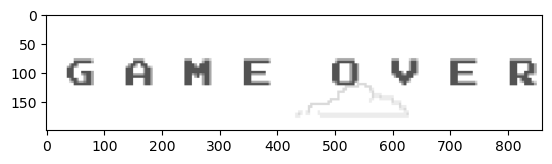

In [231]:
plt.imshow(done_cap)

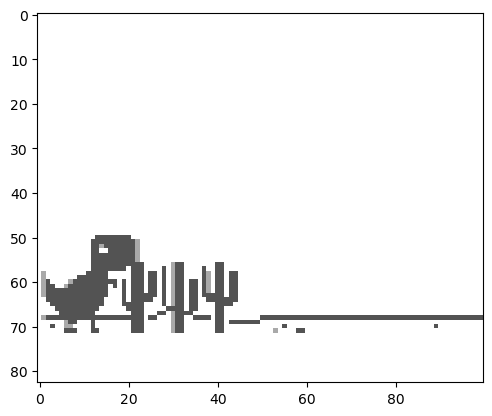

In [171]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [241]:
# Play 10 games
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
        
    print(f'Total Reward for episode {episode} is {total_reward}')
        
    

Total Reward for episode 0 is 29
Total Reward for episode 1 is 31
Total Reward for episode 2 is 37
Total Reward for episode 3 is 30
Total Reward for episode 4 is 29
Total Reward for episode 5 is 33
Total Reward for episode 6 is 31
Total Reward for episode 7 is 29
Total Reward for episode 8 is 29
Total Reward for episode 9 is 29


## TRAINING

### Create Callback 

In [16]:
# Import os for file path management
import os

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

In [17]:
# Check that the environment is okay
env_checker.check_env(env)


In [17]:
# the callback is used to save the model every n steps during training
# so that we can go back to the best model if the training is interrupted

class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        # check_freq is the number of steps between each save of the model in terms of learning steps
        # save_path is the path where the model will be saved, folder "train" in our case
        # verbose is the verbosity level: 0 no output, 1 info, 2 debug
   
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        # 'exist_ok=True' means that the directory will not be created if it already exists
   
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True
    # called after each training step
    # if the number of steps is a multiple of check_freq, the model is saved
    # the model is saved in the folder "train" with the name "best_model_{}" where {} is the number of steps
    

In [28]:
CHECKPOINT_DIR = "./train"
LOG_DIR = './logs/'

In [37]:
callback = TrainAndLoggingCallback(check_freq=2000, save_path = CHECKPOINT_DIR)

### BUILD DQN

In [24]:
# Import the DQN algorithm
from stable_baselines3 import DQN

In [38]:
# create the DQN model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, 
            buffer_size=1200000, learning_starts=1000)
# The "buffer size" parameter specifies the number of experience tuples that the replay buffer can hold
# It's not measured in bytes or any other data size 
# but rather in the number 
# in the number of experiences (or transitions)
# Each entry in the replay buffer typically consists of
# a tuple of (state, action, reward, next state, done).
# Purpose: heplps to avoid the correlation between consecutiive experiences
# and thus helps to stabilize and make the learning process more efficient.
# In the initial 1000 steps the agent's actions are random
# these initial steps allow the replay buffer to be filled with experiences
# before the actual learning begins
# In a DQN, the replay buffer stores experiences, each of which typically includes a state, the action taken in that state, the resulting reward, the next state, and a flag indicating whether the episode ended.
# Sampling refers to randomly selecting a batch of experiences from this buffer 
# to train the neural network. This random selection helps to break the correlation 
# between consecutive experiences, which is important for the stability and efficiency 
# of the learning process.
# Each training step doesn't just learn from the most recent experience 
# but rather from a diverse set of past experiences, which helps in generalizing 
# the learned policy.
# Older experiences are replaced by newer ones as the replay buffer fills up.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [39]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 37.8     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5        |
|    time_elapsed     | 29       |
|    total_timesteps  | 151      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 42.8     |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 64       |
|    total_timesteps  | 342      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.5     |
|    ep_rew_mean      | 40.5     |
|    exploration_rate | 0.954    |
| time/               |        

KeyboardInterrupt: 

### TEST IT

In [ ]:
# model = DQN.load(os.path.join('train_first', 'best_model_88000'))

In [ ]:

for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
   
    

In [1]:
import math

In [4]:
print(1/1.8)

0.5555555555555556
